In [1]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot, CoveragePlot, MarkPlot
from recommender_metrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [34]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [35]:
#only consider ratings from users who have rated over n movies
n=500
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [36]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(4020277, 4)


,userId,movieId,rating,timestamp
4712,54,1,4.0,974840421
4713,54,2,3.0,974918176
4714,54,5,3.0,974841378


In [37]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

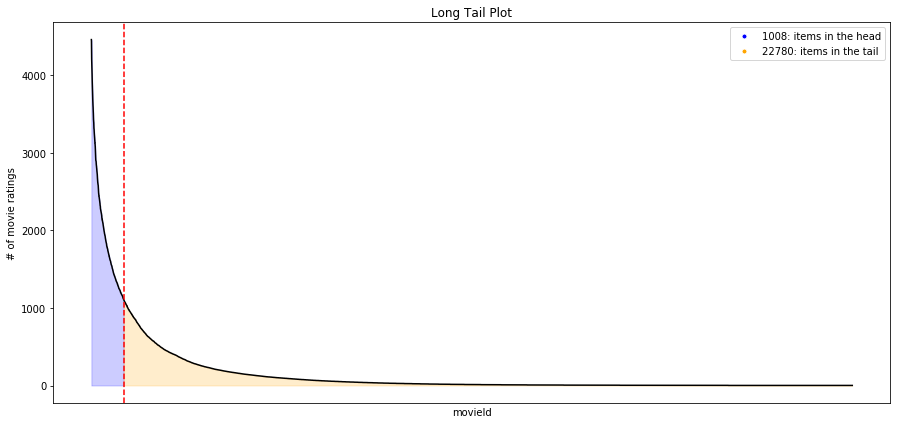

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## test/train split

In [39]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
54,"[3591, 2058, 3501, 1552, 1049, 541, 2605, 47, ..."
58,"[1, 1027, 2053, 531, 4633, 541, 4128, 5673, 55..."
91,"[5120, 1025, 1, 1032, 10, 2572, 1282, 5135, 21..."
104,"[1028, 3081, 2065, 1283, 2580, 3093, 3103, 50,..."
156,"[6, 3594, 3672, 4627, 22, 25, 2076, 541, 1030,..."


In [40]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
4712,54,1,4.0,974840421
4713,54,2,3.0,974918176
4714,54,5,3.0,974841378
4715,54,6,3.0,974836300
4716,54,10,4.0,974838872


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [41]:
#make recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
54,"[3591, 2058, 3501, 1552, 1049, 541, 2605, 47, ...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1..."
58,"[1, 1027, 2053, 531, 4633, 541, 4128, 5673, 55...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1..."
91,"[5120, 1025, 1, 1032, 10, 2572, 1282, 5135, 21...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1..."
104,"[1028, 3081, 2065, 1283, 2580, 3093, 3103, 50,...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1..."
156,"[6, 3594, 3672, 4627, 22, 25, 2076, 541, 1030,...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1..."


In [42]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [43]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    random_predictions = train_long.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions
userId,,,
54,"[3591, 2058, 3501, 1552, 1049, 541, 2605, 47, ...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1...","[95558, 3693, 3825, 2161, 5316, 2327, 35836, 8..."
58,"[1, 1027, 2053, 531, 4633, 541, 4128, 5673, 55...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1...","[3052, 2137, 1252, 54272, 6539, 7361, 1377, 29..."
91,"[5120, 1025, 1, 1032, 10, 2572, 1282, 5135, 21...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1...","[4349, 1101, 1212, 5382, 3408, 5699, 39, 589, ..."
104,"[1028, 3081, 2065, 1283, 2580, 3093, 3103, 50,...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1...","[930, 590, 5991, 1676, 5655, 1546, 111, 26713,..."
156,"[6, 3594, 3672, 4627, 22, 25, 2076, 541, 1030,...","[593, 1198, 1270, 2571, 318, 260, 296, 2762, 1...","[2124, 1589, 44587, 5388, 3439, 1459, 4641, 31..."


In [44]:
random_predictions = test.random_predictions.values.tolist()

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [45]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131231,131239,131241,131243,131248,131252,131254,131256,131260,131262
userId,,,,,,,,,,,,,,,,,,,,,
54,4.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,3.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [47]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131231,131239,131241,131243,131248,131252,131254,131256,131260,131262
54,3.733647,1.629797,0.939122,0.100145,0.740274,2.303835,0.858403,-0.058281,0.497120,2.983098,...,0.016748,-0.004816,-0.004816,-0.004816,-0.004816,-0.004816,-0.004816,-0.004816,0.001006,-0.000670
58,1.819073,1.156769,0.730718,-0.021127,0.675476,3.975516,0.829174,-0.056472,0.001146,0.813035,...,0.021262,-0.000089,-0.000089,-0.000089,-0.000089,-0.000089,-0.000089,-0.000089,0.006086,0.002895
91,3.273021,1.634855,0.694814,-0.130187,0.664799,1.721936,0.711454,0.026723,-0.177473,1.655883,...,-0.005537,-0.009004,-0.009004,-0.009004,-0.009004,-0.009004,-0.009004,-0.009004,-0.006001,0.001725
104,1.456054,-0.007316,-0.317944,0.183798,0.009355,0.665495,0.324278,0.120041,-0.208000,0.256039,...,-0.005471,-0.004308,-0.004308,-0.004308,-0.004308,-0.004308,-0.004308,-0.004308,-0.003994,0.002134
156,3.231214,3.852013,1.478071,1.778194,1.042962,3.004769,3.369287,1.168834,1.614465,4.646593,...,0.001030,0.007267,0.007267,0.007267,0.007267,0.007267,0.007267,0.007267,0.007662,-0.010162


In [48]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [49]:
get_users_predictions(156, 10, cf_model, train_long)

[541, 4361, 3578, 1459, 3998, 110, 1370, 2316, 260, 4855]

In [ ]:
#make recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

In [ ]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [ ]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

In [ ]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

In [ ]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

# Mark Plot

In [ ]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [ ]:
catalog = train_long.movieId.unique().tolist()
random_coverage = coverage(random_predictions, catalog)
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

# Coverage Plot

In [ ]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Personalization

In [ ]:
example_predictions = [
    ['A', 'B', 'C', 'D'],
    ['A', 'B', 'C', 'Y']
]

In [ ]:
personalization(predicted=example_predictions)

# Intra-list Similarity

In [ ]:
movies[movies.sum(axis=1)>0].head(5)

In [ ]:
intra_list_similarity(predicted=cf_predictions, feature_df=movies)